#### Don't forget to first create and activate the conda environment.

##### Or the [Docker/Apptainer](../README.md#running-things-in-a-container) if you prefer that instead

The [conda environment](../README.md#creating-the-conda-environment) will install everything you need to run this notebook.

```
conda env create -f environment.yml
conda activate tdc-tcr-epitope-binding-affinity-env
```

#NOTE:
This is not a [Resilience](https://resilience.com) project. The code/opinions/recommendations are mine and mine alone.

# Bioinformatics model for protein therapeutics

We'll use the [Therapeutics Data Commons](https://tdcommons.ai/) Python package to download open-source ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)) datasets that are meaningful in pharmaceutical research. In this notebook, we'll use a dataset called [TCR-Epitope Binding Affinity](https://tdcommons.ai/multi_pred_tasks/tcrepitope/).

![TCR-epitope binding](tcr-epitope-binding.png)

We show how to create a deep learning model for predicting if a T-cell receptor (TCR) and protein epitope will bind to each other. A model that can predict how well a TCR binds to an epitope can lead to more effective treatments that use immunotherapy. For example, in anti-cancer therapies it is important for the T-cell receptor to bind to the protein marker in the cancer cell so that the T-cell (actually the T-cell's friends in the immune system) can kill the cancer cell.

We'll see how to use the open-sourced [bio-embeddings](https://docs.bioembeddings.com/v0.2.3/) Python library to get the latest state-of-the-art AI model for embedding the protein sequences. In this case, we use Facebook's open-source [Evolutionary Scale Model (ESM-1b)](https://github.com/facebookresearch/esm). These embeddings turn the protein sequences into a vector of 1,280 numbers that the computer can use in a mathematical model. The vector of numbers uniquely encodes (aka embeds) a protein sequence in the same way that the [Dewey Decimal System](https://en.wikipedia.org/wiki/Dewey_Decimal_Classification) and [ISBN](https://en.wikipedia.org/wiki/ISBN) uniquely encode a book into a set of numbers (and letters). This representation is also referred to as a [latent space](https://en.wikipedia.org/wiki/Latent_space#:~:text=A%20latent%20space%2C%20also%20known,another%20in%20the%20latent%20space).

Then, we'll show how to combine this embedding with a simple neural network to create a [binary classifier](https://en.wikipedia.org/wiki/Binary_classification) for the TCR-epitope binding affinity prediction (True="They Bind", False="They don't bind").

![encoder-decoder Dewey Decimal](encoder-decoder.png)


In [1]:
import numpy as np
from tqdm.notebook import tqdm

tqdm.pandas(
    desc="Embedding protein sequences"
)  # Create fancy progress bar for Pandas apply


## Get the dataset

We are using the TDC dataset for [TCR-Epitope Binding Affinity Prediction Task](https://tdcommons.ai/multi_pred_tasks/tcrepitope/).

From the TDC website:

>T-cells are an integral part of the adaptive immune system, whose survival, proliferation, activation and function are all governed by the interaction of their T-cell receptor (TCR) with immunogenic peptides (epitopes). A large repertoire of T-cell receptors with different specificity is needed to provide protection against a wide range of pathogens. This new task aims to predict the binding affinity given a pair of TCR sequence and epitope sequence.

>Weber et al.
Dataset Description: The dataset is from Weber et al. who assemble a large and diverse data from the VDJ database and ImmuneCODE project. It uses human TCR-beta chain sequences. Since this dataset is highly imbalanced, the authors exclude epitopes with less than 15 associated TCR sequences and downsample to a limit of 400 TCRs per epitope. The dataset contains amino acid sequences either for the entire TCR or only for the hypervariable CDR3 loop. Epitopes are available as amino acid sequences. Since Weber et al. proposed to represent the peptides as SMILES strings (which reformulates the problem to protein-ligand binding prediction) the SMILES strings of the epitopes are also included. 50% negative samples were generated by shuffling the pairs, i.e. associating TCR sequences with epitopes they have not been shown to bind.

>Task Description: Binary classification. Given the epitope (a peptide, either represented as amino acid sequence or as SMILES) and a T-cell receptor (amino acid sequence, either of the full protein complex or only of the hypervariable CDR3 loop), predict whether the epitope binds to the TCR.

>Dataset Statistics: 47,182 TCR-Epitope pairs between 192 epitopes and 23,139 TCRs.

>References:

1. Weber, Anna, Jannis Born, and María Rodriguez Martínez. “TITAN: T-cell receptor specificity prediction with bimodal attention networks.” Bioinformatics 37.Supplement_1 (2021): i237-i244.

2. Bagaev, Dmitry V., et al. “VDJdb in 2019: database extension, new analysis infrastructure and a T-cell receptor motif compendium.” Nucleic Acids Research 48.D1 (2020): D1057-D1062.

3. Dines, Jennifer N., et al. “The immunerace study: A prospective multicohort study of immune response action to covid-19 events with the immunecode™ open access database.” medRxiv (2020).

>Dataset License: CC BY 4.0.

>Contributed by: Anna Weber and Jannis Born.



## Download the TCR-epitope dataset

Download and split randomly into 70% training data, 10% validation data, and 20% testing data.

In [2]:
from tdc.multi_pred import TCREpitopeBinding


In [3]:
data = TCREpitopeBinding(name="weber", path="./data")  # Download the dataset
split = data.get_split(
    method="random", seed=816, frac=[0.7, 0.1, 0.2]
)  # Split the dataset


Found local copy...
Loading...
Done!


In [4]:
print(f"Train dataset size: \t\t{len(split['train']):6,d} proteins")
print(f"Validation dataset size: \t{len(split['valid']):6,d} proteins")
print(f"Test dataset size: \t\t{len(split['test']):6,d} proteins")

Train dataset size: 		33,028 proteins
Validation dataset size: 	 4,718 proteins
Test dataset size: 		 9,436 proteins


In [5]:
train_data = split["train"]
train_data

,epitope_aa,epitope_smi,tcr,tcr_full,label
0,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSVWGTGKTYEQYF,SAVISQKPSRDICQRGTSLTIQCQVDSQVTMMFWYRQQPGQSLTLI...,1
1,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSVWGEGRSYEQYF,SAVISQKPSRDICQRGTSLTIQCQVDSQVTMMFWYRQQPGQSLTLI...,1
2,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CSATILAGVPYGEQYF,GAVVSQHPSWVICKSGTSVKIECRSLDFQATTMFWYRQFPKQSLML...,1
3,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CASSFDREVTGELFF,GAGVSQTPSNKVTEKGKYVELRCDPISGHTALYWYRQSLGQGPEFL...,1
4,FLKEKGGL,CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC...,CASSVGAGTEAFF,DGGITQSPKYLFRKEGQNVTLSCEQNLNHDAMYWYRQDPGQGLRLI...,1
...,...,...,...,...,...
33023,KLMNIQQKL,CC[C@H](C)[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@H...,CASSKPGLTDTQYF,NAGVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLI...,0
33024,TLIGDCATV,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,CASSPGQGRTHYGYTF,NAGVTQTPKFRILKIGQSMTLQCAQDMNHNYMYWYRQDPGMGLKLI...,0
33025,LLFGYPVYV,CC(C)C[C@H](N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H]...,CASSGGSLNTEAFF,NAGVTQTPKFQVLKTGQSMTLQCAQDMNHEYMSWYRQDPGMGLRLI...,0
33026,ISPRTLNAW,CC[C@H](C)[C@H](N)C(=O)N[C@@H](CO)C(=O)N1CCC[C...,CASSPSAAMNTEAFF,TVSWYQQALGQGPQFIFQYYREEENGRGNSPPRFSGLQFPNYSSEL...,0


## What do these columns mean?

The **epitope_aa** and the **tcr_full** columns are the protein (peptide) sequences for the epitope and the T-cell receptor, respectively. The letters correspond to the [standard amino acid codes](https://en.wikipedia.org/wiki/DNA_and_RNA_codon_tables).

The **epitope_smi** column is the [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) notation for the chemical structure of the epitope. We won't use this information. Instead, the ESM-1b embedder should be sufficient for the input to our binary classification model.

The **tcr** column is the CDR3 hyperloop. That's the part of the TCR that actually attaches to the epitope (assuming it binds).

The **label** column is whether the two proteins bind. 0 = No. 1 = Yes.

Our binary classification model should:
* Use the **epitope_aa** and **tcr_full** embeddings as the input
* Make a prediction if the **epitope_aa** and **tcr_full** will bind. This is the classification model's output. (0 = No, 1 = Yes)
* Use the **label** as the ground truth of the binding (i.e. what the scientific experiment says)

## The data is not shuffled

In the original datasets, the rows are sorted by label. We should randomize the row order when training our classification model.

In [6]:
# Randomize row order
train_data = split["train"].sample(frac=1, random_state=816)
validation_data = split["valid"].sample(frac=1, random_state=816)
test_data = split["test"].sample(frac=1, random_state=816)

## Getting embedding vectors for the protein sequences

I like using [bio-embeddings](https://github.com/sacdallago/bio_embeddings) as my library for determining embedding vectors for proteins. In this case, we use Facebook's open-source [Evolutionary Scale Model (ESM-1b)](https://github.com/facebookresearch/esm). These embeddings turn the protein sequences into a vector of 1,280 numbers that the computer can use in a mathematical model.

The Facebook ESM-1b model has the MIT license and was published in:

Alexander Rives, Joshua Meier, Tom Sercu, Siddharth Goyal, Zeming Lin, Jason Liu, Demi Guo, Myle Ott, C. Lawrence Zitnick, Jerry Ma, Rob Fergus. Biological structure and function emerge from scaling unsupervised learning to 250 million protein sequences. bioRxiv 622803; doi: https://doi.org/10.1101/622803  https://www.biorxiv.org/content/10.1101/622803v4

In [7]:
from bio_embeddings.embed import ESM1bEmbedder


In [8]:
embedder = (
    ESM1bEmbedder()
)  # ESM/ESM1b (https://www.biorxiv.org/content/10.1101/622803v4)

In [9]:
# Sequence from: https://www.uniprot.org/uniprot/P58426
sequence = "DDCGKLFSGCDTNADCCEGYVCRLWCKLDW"
per_residue_embedding = embedder.embed(sequence)
per_protein_embedding = embedder.reduce_per_protein(per_residue_embedding)

print(f"The shape of each embedding vector is: {np.shape(per_protein_embedding)}")
print(
    f"The embedding vector for protein sequence {sequence} is: {per_protein_embedding}"
)

The shape of each embedding vector is: (1280,)
The embedding vector for protein sequence DDCGKLFSGCDTNADCCEGYVCRLWCKLDW is: [ 0.08437356  0.24132735 -0.05913459 ...  0.05974118  0.07406691
  0.12672262]


## Create embedding function

Here we create an embedding function (calling bio-embeddings) that we can use in the `pandas.apply` method.

In [10]:
def get_embedding(sequence: str, embedder) -> np.array:
    """Gets the sequence embedding for the protein sequence

    Args:
        sequence(str): The protein sequence as a string (e.g. "DDTNAWCLCDR")
        embedder:  The bio-embedder object

    Returns:
        The per protein sequence embedding vector (1280,1)
    """
    per_residue_embedding = embedder.embed(sequence)
    per_protein_embedding = embedder.reduce_per_protein(per_residue_embedding)

    return np.array(per_protein_embedding)


In [11]:
def get_all_embedding(
    sequence_A: str, sequence_B: str, sequence_C: str, embedder
) -> tuple[np.array, np.array]:
    """Gets the sequence embedding for both protein sequences

    This allows us to process the embeddings in one pass.

    Args:
        sequence_A(str): The protein sequence as string A (e.g. "DDTNAWCLCDR")
        sequence_B(str): The protein sequence as string B (e.g. "DDSEQVENCES")
        sequence_C(str): The protein sequence as string C (e.g. "RTSEQVENCES")
        embedder:  The bio-embedder object

    Returns:
        The per protein sequence embedding vectors for A, B, and C (1280,1), (1280,1), (1280,1)
    """

    return (
        get_embedding(sequence_A, embedder),
        get_embedding(sequence_B, embedder),
        get_embedding(sequence_C, embedder),
    )

## Get embedding for the protein sequences

Returns the embedding vectors for the **epitope** and **tcr**. We'll use these embeddings as input to our model.

### Choice of CPU/GPU Hardware 

On a CPU with 8 virtual cores (4 physical cores), the `get_both_embedding` will take ~6 hours to complete. The ESM-1b model is large so you'll need ~ 16 GB of RAM.

I chose an [AWS P3 2xlarge](https://aws.amazon.com/ec2/instance-types/p3/) which includes a NVidia V100 GPU to speed that up to about 30-40 minutes. On a GPU, ESM-1b only uses about 4 GB of GPU RAM.

### Caching the embeddings to a file

In order to spare us from having to re-run a 30 minute embedding, the code below first checks if a previous run of emebddings has been cached to a pickle file. If so, then we just load that file rather than re-run the `get_both_embedding`.

### Download the Pickle files from Zenodo

I've uploaded the Pickle files onto Zenodo. You are welcome to [download them from that repository](https://zenodo.org/record/7502654).

In [12]:
import pandas as pd
import os

In [13]:
if not os.path.exists("train_data.pkl"):
    train_data[
        ["epitope_vector", "tcr_vector", "cd3r_vector"]
    ] = train_data.progress_apply(
        lambda x: get_all_embedding(x["epitope_aa"], x["tcr_full"], x["tcr"], embedder),
        axis="columns",
        result_type="expand",
    )

    train_data.to_pickle("train_data.pkl")
else:
    print("Loading previously saved train dataset embeddings.")
    train_data = pd.read_pickle("train_data.pkl")

Embedding protein sequences:   0%|          | 0/33028 [00:00<?, ?it/s]

In [14]:
if not os.path.exists("validation_data.pkl"):
    validation_data[
        ["epitope_vector", "tcr_vector", "cd3r_vector"]
    ] = validation_data.progress_apply(
        lambda x: get_all_embedding(x["epitope_aa"], x["tcr_full"], x["tcr"], embedder),
        axis="columns",
        result_type="expand",
    )
    validation_data.to_pickle("validation_data.pkl")
else:
    print("Loading previously saved validation dataset embeddings.")
    validation_data = pd.read_pickle("validation_data.pkl")

Embedding protein sequences:   0%|          | 0/4718 [00:00<?, ?it/s]

In [15]:
if not os.path.exists("test_data.pkl"):
    test_data[
        ["epitope_vector", "tcr_vector", "cd3r_vector"]
    ] = test_data.progress_apply(
        lambda x: get_all_embedding(x["epitope_aa"], x["tcr_full"], x["tcr"], embedder),
        axis="columns",
        result_type="expand",
    )
    test_data.to_pickle("test_data.pkl")
else:
    print("Loading previously saved test dataset embeddings.")
    test_data = pd.read_pickle("test_data.pkl")

Embedding protein sequences:   0%|          | 0/9436 [00:00<?, ?it/s]

### Delete the embedder

We're done using the embedder so let's delete it and free up RAM.

In [16]:
del embedder

### Let's look at our new dataframe with the protein embeddings

In [17]:
train_data

,epitope_aa,epitope_smi,tcr,tcr_full,label,epitope_vector,tcr_vector,cd3r_vector
11113,LVLSVNPYV,CC(C)C[C@H](N)C(=O)N[C@H](C(=O)N[C@@H](CC(C)C)...,CASGAPSYEQYF,DAGITQSPRYKITETGRQVTLMCHQTWSHSYMFWYRQDLGHGLRLI...,1,"[0.15007846, 0.012214901, 0.0553561, 0.0782113...","[0.08787762, 0.1292523, -0.13622208, -0.080933...","[0.103608824, 0.08061151, -0.003718689, 0.1836..."
27246,RLRPGGKKR,CC(C)C[C@H](NC(=O)[C@@H](N)CCCNC(=N)N)C(=O)N[C...,CASSLLAGDFSYNEQFF,GAGVSQSPRYKVTKRGQDVALRCDPISGHVSLYWYRQALGQGPEFL...,0,"[0.071283095, -0.0065888097, 0.18869965, 0.242...","[0.04202661, 0.15670273, -0.15199058, -0.02398...","[0.059112843, 0.063063234, -0.040574, 0.171030..."
32541,TLDSKTQSL,CC(C)C[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](CCC(N)=...,CSVGWRQNTEAFF,TIQCQVDSQVTMIFWYRQQPGQSLTLIATANQGSEATYESGFVIDK...,0,"[0.06770904, 0.062482722, 0.01739933, 0.205358...","[0.03461151, 0.21730861, -0.17000784, -0.09014...","[0.13998987, 0.015931845, 0.052262798, 0.13999..."
2925,GILGFVFTL,CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@@H](CC(C)C)C...,CASKARGSPLHF,EAQVTQNPRYLITVTGKKLTVTCSQNMNHEYMSWYRQDPGLGLRQI...,1,"[0.15694445, 0.09897915, 0.05394974, 0.1499010...","[0.034102954, 0.17318194, -0.16215082, -0.0817...","[0.060450774, 0.048615154, 0.08319596, 0.20494..."
8283,ITEEVGHTDLMAAY,CC[C@H](C)[C@H](N)C(=O)N[C@H](C(=O)N[C@@H](CCC...,CASSQGPGGDGELFF,HLVMGMTNKKSLKCEQHMGHRAMYWYKQKAKKPPELMFVYSYEKLS...,1,"[0.14460172, 0.0751254, -0.002550015, 0.126723...","[0.098953016, 0.11834457, -0.19872111, -0.0934...","[0.06118077, 0.041878883, -0.0023343195, 0.224..."
...,...,...,...,...,...,...,...,...
11255,KLSYGIATV,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](Cc1ccc(O)cc...,CASSRDYNTGELFF,TAGITQAPTSQILAAGRSMTLRCTQDMRHNAMYWYRQDLGLGLRLI...,1,"[0.06866268, 0.025249027, 0.051295787, 0.20155...","[0.09340844, 0.096242145, -0.114671804, -0.034...","[0.101738326, 0.0414281, -0.033525746, 0.12280..."
19674,SFHSLHLLF,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc1...,CASSPRGSGESTDTQYF,HLVMGMTNKKSLKCEQHMGHRAMYWYKQKAKKPPELMFVYSYEKLS...,0,"[0.047729272, 0.06474179, -0.010509114, 0.2196...","[0.08440966, 0.15677722, -0.18194607, -0.13834...","[0.07973641, 0.011867488, 0.050882634, 0.18656..."
15677,WICLLQFAY,CC[C@H](C)[C@H](NC(=O)[C@@H](N)Cc1c[nH]c2ccccc...,CASSAGTGGITDTQYF,DAEITQSPRHKITETGRQVTLACHQTWNHNNMFWYRQDLGHGLRLI...,1,"[0.09062517, -0.0436092, -0.0027409792, 0.2049...","[0.07503189, 0.11690669, -0.1628319, -0.059223...","[0.086965814, 0.016140556, 0.027268834, 0.1980..."
164,LLQTGIHVRVSQPSL,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@@H](NC(=O)[C@H...,CSASLDSGTQETQYF,GAVVSQHPSWVICKSGTSVKIECRSLDFQATTMFWYRQFPKQSLML...,1,"[0.094358966, 0.10174878, 0.07946197, 0.205965...","[-0.0021072202, 0.32087207, -0.16127153, -0.00...","[0.14066386, -0.06022651, -0.042550024, 0.1822..."


In [18]:
test_data[["epitope_vector", "tcr_vector", "cd3r_vector", "label"]]

,epitope_vector,tcr_vector,cd3r_vector,label
1966,"[0.22964668, -0.0051608724, 0.07318806, 0.1722...","[0.0617666, 0.13244663, -0.1996336, -0.0599712...","[0.08725504, 0.06063491, -0.019930111, 0.17030...",0
9408,"[0.05502026, 0.054593395, 0.07720412, 0.249403...","[0.039608102, 0.14005327, -0.2274739, -0.03252...","[0.083981924, 0.04563091, -0.036207624, 0.1872...",0
3168,"[0.06632361, 0.06506988, 0.0304368, 0.21584058...","[0.07430229, 0.09793043, -0.21498163, -0.03241...","[0.041769687, 0.044820223, -0.0289787, 0.25631...",0
956,"[-0.0082874615, 0.105047055, -0.053225227, 0.1...","[0.10166727, 0.09984901, -0.1839389, -0.068058...","[0.10005653, 0.054476682, 0.02775102, 0.149906...",1
5034,"[0.14362255, -0.014753604, 0.1276768, 0.052741...","[0.08320723, 0.0792897, -0.12207786, -0.013281...","[0.070882685, 0.07317776, -0.09497682, 0.17622...",1
...,...,...,...,...
3290,"[0.071621455, 0.11859722, 0.099984914, 0.16573...","[0.08800391, 0.16937731, -0.20033324, -0.03200...","[0.052170813, 0.058280513, -0.012739021, 0.193...",1
5774,"[0.03897657, 0.108736955, -0.05208558, 0.08545...","[0.024393525, 0.15680152, -0.1596915, -0.00704...","[0.11080564, 0.035638344, 0.11545701, 0.160686...",1
164,"[0.15930286, -0.13706023, 0.14785059, 0.140019...","[0.067326225, 0.03165519, -0.106503054, 0.0064...","[0.057919018, 0.07792831, 0.01406895, 0.127030...",0
5373,"[0.06866268, 0.025249027, 0.051295787, 0.20155...","[0.04054256, 0.13251191, -0.14107871, -0.01545...","[0.052666984, -0.022484256, -0.014572122, 0.19...",1


### We want to merge the input vectors

We have 2 inputs for our model: **epitope_vector** and **tcr_vector**. We have many choices of how to use these in the model. 

There's no real "right" way to put them together so let's just merge the epitope and TCR vectors into a single vector. 

This will be the input to our binary classification model.

You can try any modifications you want if you don't like to concatenate them.

In [19]:
train_data["input"] = train_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)
validation_data["input"] = validation_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)
test_data["input"] = test_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)

### Pull out the X and y datasets

In [20]:
X_train = train_data["input"]
y_train = train_data["label"]

X_validation = validation_data["input"]
y_validation = validation_data["label"]

X_test = test_data["input"]
y_test = test_data["label"]

### We should scale the input data

[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) just removes the mean and normalizes by the standard deviation. It's usually a good idea for pre-processing the input dataset.

In [21]:
from sklearn.preprocessing import StandardScaler

ss_train = StandardScaler()
X_train = ss_train.fit_transform(train_data["input"].to_list())

ss_validation = StandardScaler()
X_validation = ss_validation.fit_transform(validation_data["input"].to_list())

ss_test = StandardScaler()
X_test = ss_test.fit_transform(test_data["input"].to_list())

### Use XGBoost to create binary classifier

[XGBoost](https://xgboost.readthedocs.io/en/stable/get_started.html) is a good Python library to train models using Gradient Boosted Trees. We'll use this to create our binary classifier. If you have a GPU, then you can add the `tree_method="gpu_hist"` parameter. Training on the GPU takes only seconds. Training on the CPU takes ~6 minutes.

NOTE: Scikit-learn is another good choice for training models. However, I found that it took ~ 45 minutes to train a SVM classifier and the results weren't any better.

In [22]:
from xgboost import XGBClassifier

from torch import cuda

if cuda.is_available():  # GPU is available to use
    print("Using GPU acceleration")
    clf = XGBClassifier(
        tree_method="gpu_hist", random_state=816, verbosity=2
    )  # If GPU is available
else:  # No GPU
    clf = XGBClassifier(random_state=816, verbosity=1)

Using GPU acceleration


### Train the model

In [23]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=816, ...)

### Evaluate how the model performs on unseen data

We'll print out the [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). These are calculated on the test_data. The model was never trained on the test_data so it is a good approximation of how the model will perform on future unseen data.

In [24]:
CLASS_NAMES = ["No bind", "Bind"]

In [25]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

In [26]:
predictions_gradient = clf.predict(X_test)

print(classification_report(y_test, predictions_gradient, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

     No bind       0.73      0.76      0.75      4708
        Bind       0.75      0.72      0.74      4728

    accuracy                           0.74      9436
   macro avg       0.74      0.74      0.74      9436
weighted avg       0.74      0.74      0.74      9436



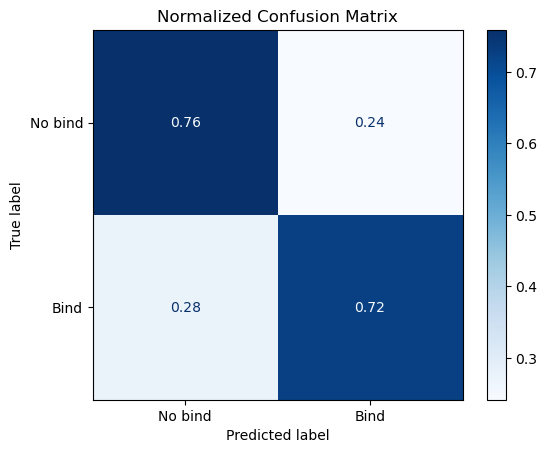

In [27]:
# creating a confusion matrix
cm_norm = confusion_matrix(y_test, predictions_gradient, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=CLASS_NAMES)
disp.plot(cmap="Blues")

disp.ax_.set_title("Normalized Confusion Matrix")
disp.ax_.grid(False)

### PyTorch model

Let's also try a deep learning model built with [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/). Lightning handles much of the boilerplate code so that we just have to define our model.

Here we'll use a simple binary classification neural network to compare/contrast the two inputs and decide if they bind (or not).

### Let's reload the embedding dataset from the Pickle

This is just in case this section is run independently of the last. 

If you don't have the pickle files, then re-run the last section of this notebook to calculate the embeddings and save them to Pickle files.

In [28]:
train_data = pd.read_pickle("train_data.pkl")
validation_data = pd.read_pickle("validation_data.pkl")
test_data = pd.read_pickle("test_data.pkl")

In [29]:
train_data["input"] = train_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)
validation_data["input"] = validation_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)
test_data["input"] = test_data.apply(
    lambda x: np.concatenate((x["epitope_vector"], x["tcr_vector"])), axis="columns"
)


In [30]:
from torch import nn
import torch.backends
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryF1Score,
    BinaryAUROC,
    ConfusionMatrix,
)

In [31]:
pl.seed_everything(816)  # Random seed to ensure deterministic training

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True

Global seed set to 816


In [32]:
class Lit_Binding_Model(pl.LightningModule):
    """PyTorch Lightning Module

    Defines the PyTorch model. Defines the training, validation, and testing for the model.

    """

    def __init__(self, kwargs):
        super().__init__()

        # Training parameters
        self.learning_rate = kwargs["learning_rate"]
        self.train_batch_size = kwargs["train_batch_size"]
        self.val_batch_size = kwargs["validation_batch_size"]
        self.test_batch_size = kwargs["test_batch_size"]

        self.X_train = kwargs["X_train"]
        self.y_train = kwargs["y_train"]

        self.X_validation = kwargs["X_validation"]
        self.y_validation = kwargs["y_validation"]

        self.X_test = kwargs["X_test"]
        self.y_test = kwargs["y_test"]

        # Model layers
        self.layer1 = nn.Linear(kwargs["input_dim"], 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer_out = nn.Linear(256, 1)

        # Metrics
        self.train_accuracy = BinaryAccuracy()
        self.val_accuracy = BinaryAccuracy()
        self.test_accuracy = BinaryAccuracy()

        self.train_F1 = BinaryF1Score()
        self.val_F1 = BinaryF1Score()
        self.test_F1 = BinaryF1Score()

        self.train_auc = BinaryAUROC()
        self.val_auc = BinaryAUROC()
        self.test_auc = BinaryAUROC()

        self.confusion_matrix = ConfusionMatrix(
            task="binary", num_classes=2, normalize="true"
        )

    def forward(self, x):
        """Define forward pass for model

        Args:
            x: Input to model
        """

        # Define our model

        x = x.view(x.size(0), -1)  # Reshape input vector

        # Normalize the input embedding vector to mean 0 and standard deviation 1
        x = nn.functional.normalize(x)

        x = self.layer1(x)
        x = nn.ReLU()(x)

        x = self.layer2(x)
        x = nn.ReLU()(x)

        # Add dropout layer with 0.2 probability of dropout
        x = nn.Dropout(p=0.2)(x)

        x = self.layer_out(x)
        x = nn.Sigmoid()(x)

        return x

    def configure_optimizers(self):
        """Configure the SGD optimizer"""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        """Defines what happens at each step in training

        batch:  A batch from the data loader
        batch_idx(int): The index of the batch
        """
        # training_step defines the train loop.
        input_vector, label = batch
        prediction = self.forward(input_vector)

        loss = nn.BCELoss()(prediction, label)

        self.train_accuracy.update(prediction, label)

        self.train_F1.update(prediction, label)
        self.train_auc.update(prediction, label)

        return loss

    def validation_step(self, batch, batch_idx):
        """Defines what happens at each step in validation

        batch:  A batch from the data loader
        batch_idx(int): The index of the batch
        """
        # training_step defines the train loop.
        input_vector, label = batch
        prediction = self.forward(input_vector)
        loss = nn.BCELoss()(prediction, label)

        self.val_accuracy.update(prediction, label)
        self.val_F1.update(prediction, label)
        self.val_auc.update(prediction, label)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        self.log("val_F1", self.val_F1, prog_bar=True)
        self.log("val_AUCROC", self.val_auc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        """Defines what happens at each step in testing

        batch:  A batch from the data loader
        batch_idx(int): The index of the batch
        """
        input_vector, label = batch
        prediction = self.forward(input_vector)
        loss = nn.BCELoss()(prediction, label)

        self.test_accuracy.update(prediction, label)
        self.test_F1.update(prediction, label)
        self.test_auc.update(prediction, label)

        self.confusion_matrix.update(prediction, label)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)
        self.log("test_F1", self.test_F1, prog_bar=True)
        self.log("test_AUCROC", self.test_auc, prog_bar=True)

    def train_dataloader(self):
        """Defines the PyTorch data loader for the training data"""
        train = TensorDataset(
            torch.Tensor(self.X_train),
            torch.Tensor(np.expand_dims(self.y_train, axis=1)),
        )
        return DataLoader(train, batch_size=self.train_batch_size, shuffle=True)

    def val_dataloader(self):
        """Defines the PyTorch data loader for the validation data"""
        validate = TensorDataset(
            torch.Tensor(self.X_validation),
            torch.Tensor(np.expand_dims(self.y_validation, axis=1)),
        )
        return DataLoader(validate, batch_size=self.val_batch_size, shuffle=False)

    def test_dataloader(self):
        """Defines the PyTorch data loader for the testing data"""
        test = TensorDataset(
            torch.Tensor(self.X_test), torch.Tensor(np.expand_dims(self.y_test, axis=1))
        )
        return DataLoader(test, batch_size=self.test_batch_size, shuffle=False)

In [33]:
model_parameters = {
    "input_dim": X_train.shape[1],  # vector of 2560 elements
    "learning_rate": 1e-3,
    "X_train": X_train,
    "y_train": y_train,
    "X_validation": X_validation,
    "y_validation": y_validation,
    "X_test": X_test,
    "y_test": y_test,
    "train_batch_size": 128,
    "validation_batch_size": 64,
    "test_batch_size": 32,
}

binding_model = Lit_Binding_Model(model_parameters)


### Add some checkpoints for training

This will give us a nice progress bar to track training. It will also save the best model checkpoints and stop training early if the model validation loss doesn't improve after 10 steps.

In [34]:
progress_bar = TQDMProgressBar(refresh_rate=20)


In [35]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
)


In [36]:
model_checkpoint = ModelCheckpoint(monitor="val_loss")


### Create the PyTorch Lightning trainer module

In [37]:
# Initialize a trainer
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=50,
    callbacks=[progress_bar, early_stopping, model_checkpoint],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Train that model

In [38]:
# Train the model ⚡
trainer.fit(binding_model)


Missing logger folder: /users/tony_reina/personal_projects/tdc-tcr-epitope-antibody-binding/notebooks/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name             | Type                  | Params
------------------------------------------------------------
0  | layer1           | Linear                | 1.3 M 
1  | layer2           | Linear                | 131 K 
2  | layer_out        | Linear                | 257   
3  | train_accuracy   | BinaryAccuracy        | 0     
4  | val_accuracy     | BinaryAccuracy        | 0     
5  | test_accuracy    | BinaryAccuracy        | 0     
6  | train_F1         | BinaryF1Score         | 0     
7  | val_F1           | BinaryF1Score         | 0     
8  | test_F1          | BinaryF1Score         | 0     
9  | train_auc        | BinaryAUROC           | 0     
10 | val_auc          | BinaryAUROC           | 0     
11 | test_auc         | BinaryAUROC           | 0     
12 | confusion_matrix | BinaryConfusionMatrix | 0     
---------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### How does the model perform on unseen data?

In [39]:
trainer.test()


Restoring states from the checkpoint path at /users/tony_reina/personal_projects/tdc-tcr-epitope-antibody-binding/notebooks/lightning_logs/version_0/checkpoints/epoch=10-step=2849.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /users/tony_reina/personal_projects/tdc-tcr-epitope-antibody-binding/notebooks/lightning_logs/version_0/checkpoints/epoch=10-step=2849.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_AUCROC        │    0.8552761077880859     │
│          test_F1          │    0.7866271138191223     │
│         test_acc          │    0.7788257598876953     │
│         test_loss         │     0.480549693107605     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.480549693107605,
  'test_acc': 0.7788257598876953,
  'test_F1': 0.7866271138191223,
  'test_AUCROC': 0.8552761077880859}]

### Load the best model from the training and do inference

Loads the model from the best checkpoint (the one with the lowest validation loss). Run inference on the test dataset.

Note: We loop through the `X_test` dataset, but you can put any embedding vector here as input.

In [40]:
from tqdm.notebook import tqdm


#### Reload the best model from the PyTorch checkpoint

In [41]:
binding_model = Lit_Binding_Model.load_from_checkpoint(
    model_checkpoint.best_model_path, kwargs=model_parameters
)

binding_model.eval()  # This sets the model to inference-only

Lit_Binding_Model(
  (layer1): Linear(in_features=2560, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (train_accuracy): BinaryAccuracy()
  (val_accuracy): BinaryAccuracy()
  (test_accuracy): BinaryAccuracy()
  (train_F1): BinaryF1Score()
  (val_F1): BinaryF1Score()
  (test_F1): BinaryF1Score()
  (train_auc): BinaryAUROC()
  (val_auc): BinaryAUROC()
  (test_auc): BinaryAUROC()
  (confusion_matrix): BinaryConfusionMatrix()
)

#### Make predictions using our trained model

In [42]:
def make_predictions(model, x_dataset: np.ndarray):
    """Use model to make binding predictions

    Args:
        model: The Pytorch model to use for inference
        x_dataset: A Numpy array of embedding vectors.

    """
    predictions_pytorch = []

    with torch.no_grad():

        for x in tqdm(x_dataset, desc="Making predictions on the dataset"):

            # Convert the NumPy vector to a PyTorch tensor
            tensor_x = torch.Tensor(np.expand_dims(x, 0))

            prediction = model(tensor_x)

            if prediction > 0.5:  # Predict binds?
                predictions_pytorch.append(1)  # Binds
            else:
                predictions_pytorch.append(0)  # Doesn't bind

    return np.array(predictions_pytorch)

In [43]:
predictions_pytorch = make_predictions(binding_model, X_test)


Making predictions on the dataset:   0%|          | 0/9436 [00:00<?, ?it/s]

### Get model performance on test dataset

In [44]:
print(classification_report(y_test, predictions_pytorch, target_names=CLASS_NAMES))


              precision    recall  f1-score   support

     No bind       0.80      0.74      0.77      4708
        Bind       0.76      0.81      0.79      4728

    accuracy                           0.78      9436
   macro avg       0.78      0.78      0.78      9436
weighted avg       0.78      0.78      0.78      9436



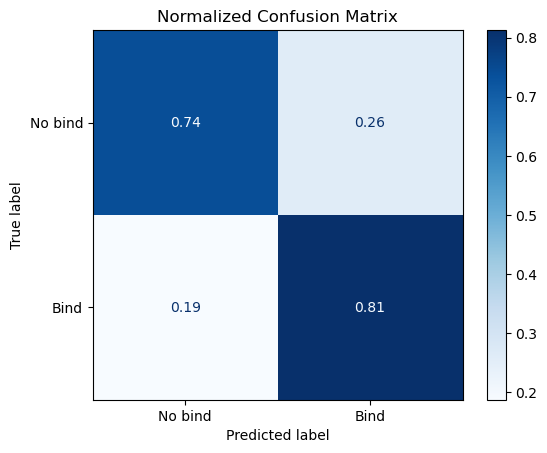

In [45]:
# creating a confusion matrix
cm_norm = confusion_matrix(y_test, predictions_pytorch, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=CLASS_NAMES)
disp.plot(cmap="Blues")

disp.ax_.set_title("Normalized Confusion Matrix")
disp.ax_.grid(False)


## Further experiments

Hopefully this notebook has given you a good understanding of how to create these models. The PyTorch model I used was a very simple multi-layered perceptron, but it actually did slightly better than the XGBoost model. What would happen if we also added the SMILES information as input features? Perhaps you can come up with models that will perform even better?